In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/notebook810eb1472d/_output_.zip
/kaggle/input/notebook810eb1472d/__results__.html
/kaggle/input/notebook810eb1472d/__notebook__.ipynb
/kaggle/input/notebook810eb1472d/__output__.json
/kaggle/input/notebook810eb1472d/custom.css
/kaggle/input/notebook810eb1472d/__results___files/__results___2_0.jpg
/kaggle/input/notebook810eb1472d/__results___files/__results___2_0.png


In [2]:
import zipfile
import os

# Path to the uploaded zip file
zip_path = "/kaggle/input/notebook810eb1472d/_output_.zip"
extract_path = "/kaggle/working/frames"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check contents
os.listdir(extract_path)


['__pycache__', 'combined_dataset.csv', 'frames']

Epoch 1/10: 100%|██████████| 16248/16248 [39:47<00:00,  6.80it/s]


Train Loss: 13284.3566, Accuracy: 56.63%
Validation Accuracy: 65.79%
✅ Best model saved.


Epoch 2/10: 100%|██████████| 16248/16248 [39:01<00:00,  6.94it/s]


Train Loss: 11086.5344, Accuracy: 65.79%
Validation Accuracy: 70.38%
✅ Best model saved.


Epoch 3/10: 100%|██████████| 16248/16248 [35:40<00:00,  7.59it/s]


Train Loss: 10080.8108, Accuracy: 70.07%
Validation Accuracy: 73.73%
✅ Best model saved.


Epoch 4/10: 100%|██████████| 16248/16248 [38:39<00:00,  7.00it/s]


Train Loss: 9413.1297, Accuracy: 72.58%
Validation Accuracy: 74.60%
✅ Best model saved.


Epoch 5/10: 100%|██████████| 16248/16248 [37:01<00:00,  7.31it/s]


Train Loss: 8942.8440, Accuracy: 74.33%
Validation Accuracy: 76.16%
✅ Best model saved.


Epoch 6/10: 100%|██████████| 16248/16248 [38:19<00:00,  7.07it/s]


Train Loss: 8589.8301, Accuracy: 75.57%
Validation Accuracy: 78.51%
✅ Best model saved.


Epoch 7/10: 100%|██████████| 16248/16248 [37:42<00:00,  7.18it/s]


Train Loss: 8248.6517, Accuracy: 76.62%
Validation Accuracy: 78.40%


Epoch 8/10: 100%|██████████| 16248/16248 [37:09<00:00,  7.29it/s]


Train Loss: 8034.9690, Accuracy: 77.39%
Validation Accuracy: 79.06%
✅ Best model saved.


Epoch 9/10: 100%|██████████| 16248/16248 [38:49<00:00,  6.97it/s]


Train Loss: 7834.8076, Accuracy: 78.07%
Validation Accuracy: 76.56%


Epoch 10/10: 100%|██████████| 16248/16248 [39:00<00:00,  6.94it/s]


Train Loss: 7679.3025, Accuracy: 78.62%
Validation Accuracy: 80.20%
✅ Best model saved.


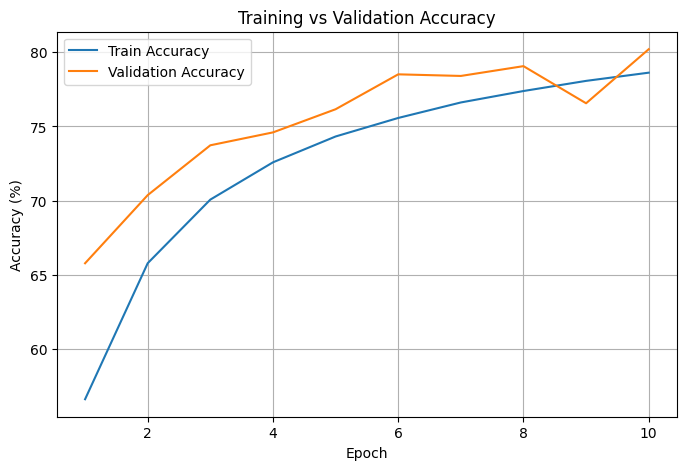

/tmp/ipykernel_19/4207215684.py:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



--- Test Set Performance ---
                     precision    recall  f1-score   support

          Alert (0)       0.82      0.77      0.80     39276
Slightly Drowsy (1)       0.76      0.86      0.81     37246
         Drowsy (2)       0.83      0.77      0.80     38164

           accuracy                           0.80    114686
          macro avg       0.80      0.80      0.80    114686
       weighted avg       0.80      0.80      0.80    114686


✅ Test Accuracy: 80.16%

Confusion Matrix:
 [[30380  5158  3738]
 [ 2940 32166  2140]
 [ 3727  5054 29383]]


In [3]:
# -------------------------
# Imports
# -------------------------
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# -------------------------
# Load CSV & Clean
# -------------------------
csv_path = "/kaggle/working/frames/combined_dataset.csv"
df = pd.read_csv(csv_path)

df['img_path'] = df['img_path'].apply(lambda x: os.path.join("/kaggle/working/frames/frames", os.path.basename(x)))
df['Label'] = df['Label'].map({0: 0, 5: 1, 10: 2})

tabular_cols = ['EAR', 'MAR', 'Head_Tilt', 'Head_Nod']

# Handle infinities
df[tabular_cols] = df[tabular_cols].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=tabular_cols).reset_index(drop=True)

# Scale tabular features
scaler = StandardScaler()
df[tabular_cols] = scaler.fit_transform(df[tabular_cols])

# -------------------------
# Train / Validation / Test Split
# -------------------------
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['Label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['Label'], random_state=42)

# -------------------------
# Dataset Class
# -------------------------
class DrowsinessCombinedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['img_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        tabular = torch.tensor(row[tabular_cols].astype(np.float32).values, dtype=torch.float32)
        label = torch.tensor(int(row['Label'])).long()
        return image, tabular, label

# -------------------------
# Image Transformations
# -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# -------------------------
# Data Loaders
# -------------------------
train_loader = DataLoader(DrowsinessCombinedDataset(train_df, transform), batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(DrowsinessCombinedDataset(val_df, transform), batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(DrowsinessCombinedDataset(test_df, transform), batch_size=32, shuffle=False, num_workers=0)

# -------------------------
# Model
# -------------------------
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, 3, stride, 1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class MobileNetWithTabularLSTM(nn.Module):
    def __init__(self, num_tabular_features, num_classes=3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(32, 64, 1),
            DepthwiseSeparableConv(64, 128, 2),
            DepthwiseSeparableConv(128, 128, 1),
            DepthwiseSeparableConv(128, 256, 2),
            DepthwiseSeparableConv(256, 256, 1),
            nn.AdaptiveAvgPool2d(1)
        )

        self.lstm = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(128 + num_tabular_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, tabular):
        x_img = self.cnn(image)
        x_img = torch.flatten(x_img, 1)
        x_img = x_img.unsqueeze(1)
        x_lstm, _ = self.lstm(x_img)
        x_lstm = x_lstm[:, -1, :]
        x = torch.cat([x_lstm, tabular], dim=1)
        return self.fc(x)

# -------------------------
# Training Setup
# -------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetWithTabularLSTM(num_tabular_features=len(tabular_cols)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

import matplotlib.pyplot as plt

train_accuracies = []
val_accuracies = []
best_val_acc = 0.0
best_model_path = "/kaggle/working/best_model.pth"

# -------------------------
# Training Loop
# -------------------------
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, tabular, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, tabular)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_accuracies.append(train_acc)
    print(f"Train Loss: {total_loss:.4f}, Accuracy: {train_acc:.2f}%")

    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, tabular, labels in val_loader:
            images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
            outputs = model(images, tabular)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    print(f"Validation Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print("✅ Best model saved.")

# -------------------------
# Accuracy Plot
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("/kaggle/working/accuracy_plot.png")
plt.show()






# -------------------------
# Test Evaluation (Best Model)
# -------------------------
model.load_state_dict(torch.load(best_model_path))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, tabular, labels in test_loader:
        images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
        outputs = model(images, tabular)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)

print("\n--- Test Set Performance ---")
print(classification_report(all_labels, all_preds, target_names=["Alert (0)", "Slightly Drowsy (1)", "Drowsy (2)"]))
print(f"\n✅ Test Accuracy: {test_accuracy:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:\n", cm)

